# Variational Quantum Regression

### Adapted by
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Source
- Qiskit Tutorial. “Variational Quantum Regression”, in *Learn Quantum Computation Using Qiskit. Textbook*, 2020.<br/>https://qiskit.org/textbook/ch-demos/variational-quantum-regression.html

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand{\braket}[2]{\left\langle{#1}\vert{#2}\right\rangle}$
## Introduction

In this example we will implement a Qiskit variational quantum algorithm implementing a simple linear regression. Given a training data set of two vectors $(\vec{x}, \vec{y})$ (each of length $N$), we will demonstrate the approach by fitting pairs of data points $(x_{i}, y_{i})$ with a line satisfying the following linear equation:

$$\vec{y} = a \vec{x} + b + \epsilon$$

The task will be to determine coefficients $a$ and $b$ that minimise the distance $\epsilon$ of the linear model from the training data set. The demonstrated method offers no advantage over equivalent classical algorithms, which typically rely on the ([Least Squares Method](https://doi.org/10.1016/j.proeng.2012.09.545)). However, the example is valuable as it illustrates that a variational model can be employed not only as part of the data preparation/processing quantum circuit, but also to calculate the cost function driving the optimisation process. The code also demonstrates how to use non-Qiskit optimisers (such as *scipy*) within Qiskit.

Note that the approach taken here will be extended and demonstrated to allow polynomial fitting of data as well. 

## The Method

We will encode a normalised vector $\vec{y}$ as a quantum state $\ket{y}$, with $C_y$ as a normalisation factor: 

$$\ket{y} = \frac{1}{C_{y}} \vec{y} =  \frac{1}{C_{y}} (a \vec{x} + b )$$

We will identify $a$ and $b$ in the optimisation process, looking for the approximation of state $\ket{y}$ with the following state:

$$\ket{\phi} = \frac{1}{C_{\phi}}(a\vec{x} + b)$$ 

where $C_{\phi}$ again a normalisation factor and the state $\ket{\phi}$ is arrived at in a sequence of intermediate states:

$$\ket{\phi_{0}}, \ket{\phi_{1}}, ..., \ket{\phi_{n}}$$

Where each $\ket{\phi_{i}}$ is an improved approximation of the quantum state $\ket{y}$, starting with $\ket{\phi_{0}} = \ket{\phi}(a_{0}, b_{0})$ where $a_{0}$ and $b_{0}$ are the initial guess of what are the likely values $a$ and $b$. The subsequent $\ket{\phi_{i}} = \ket{\phi}(a_{i}, b_{i})$ with $a_{i}$ and $b_{i}$ generated by the optimiser. The choice of the initial values $a_{0}$ and $b_{0}$ is very important as some optimisers are sensitive to the starting point. We found that the initial values of (0.5, 0.5) as recommended by the *Qiskit tutorial* are very poor, and the starting point very close to zero (0.0001, 0.0001) is a much better choice (note that some *scipy*/*Qiskit* optimisers will fail with zeros).

### Cost Function

The search for the optimum $a$ and $b$, and thus $\ket{\phi}$, will rely on the process of minimising the cost function $C_{p}$, which will be minimum when the similarity between $\ket{y}$ and $\ket{\phi}$ is greatest. This will be accomplished by calculating the *inner product* of $\braket{y}{\phi}$, which is a projection of $\ket{\phi}$ onto $\ket{y}$ and thus for normalised vectors, the inner product is 1 when both vectors are equal, and is 0 when they are orthogonal.

The proposed cost function hence is:
$$C_{p} = \big(1 - \braket{y}{\phi}\big)^2$$

As we can see the cost function is $0$ when vectors $\ket{y}$ and $\ket{\phi}$ are equal, otherwise it is above 0. We can minimise the cost function by using a classical machine learning algorithms (such as gradient descent or COBYLA), however, the calculation of its inner product can be performed using a purely quantum method, which can be executed on a quantum machine. 

## Quantum Implementation of the Inner Product

For the details of proving the calculation correct we refer the reader to the original *Qiskit Tutorial* (2020). 

The algorithm will utilise a quantum circuit which will be built into the cost function. It will rely on the amplitude encoding of sample data, which ensures that measured expectation values of the composite qubit states corresponds to data point values.

We encode normalised $ax + b$ into half of the circuit qubits, and normalised $y$ into the remaining ones. These encoded values will constrain possible circuit states. 

The Hadamard gate $H$ will be placed in the lowest qubit (Qiskit orders its qubits with the last qubit corresponding to the left of the tensor product), to allow measuring the result expectation value, which can be shown to imply the value of the inner product to be used in further calculation .

It is worth noting that amplitude encoding of vectors of size $N$ requires $n = \left\lceil log_2(N)\right\rceil$ qubits. To make things simpler we will assume the length of data vectors $\vec{x}$ and $\vec{y}$ to be $N = 2^n$. For example, is we were to compute the inner product of length-8 vectors, we would require 4 qubits ($8 + 8 = 16 = 2^4$) to encode the state.

Finally, in order to measure the probability of measuring the bottom (leftmost) qubit as $\ket{0}$ in the computational basis on a quantum computer, we would need to perform the measurement many times and compute the expectation value of that result.

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/Dropbox/Dev/Python/qiskit/projects/ts/tqcebt_qtsa',
 '/home/jacob/anaconda3/envs/qiskit/lib/python38.zip',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/lib-dynload',
 '',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages/IPython/extensions',
 '/home/jacob/.ipython',
 '.']

In [2]:
# importing necessary packages
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.utils import algorithm_globals
from qiskit.tools.visualization import plot_histogram
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from utils import *
%matplotlib inline

In [3]:
shots = 1000
backend = Aer.get_backend('qasm_simulator')
# backend = Aer.get_backend('statevector_simulator')
debug = True

## Data Preparation

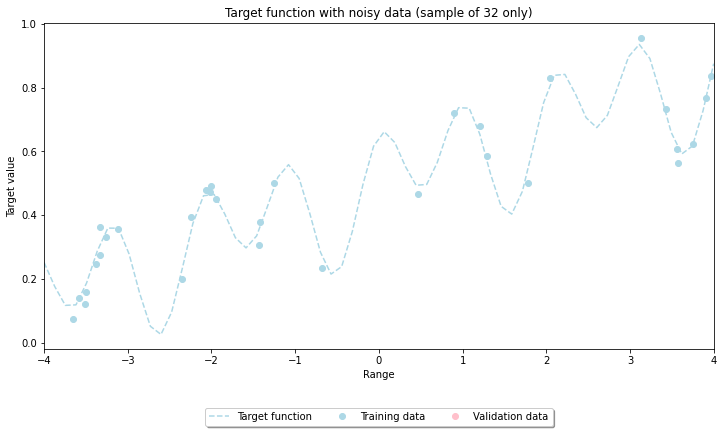

In [4]:
### Start random process
algorithm_globals.random_seed = 2022

### Data settings
samples_train = 32
samples_valid = 0
samples = samples_train+samples_valid
samples_hi_res = samples*2
train_pc = samples_train / samples

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_trig_trend()

### Collect target function parameters
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
eps = f.eps()
T = (ub - lb)

### Prepare all X and y data
X_all = np.linspace(lb, ub, num=samples_hi_res)
y_all = f.fun(X_all)
X_train = (ub_train - lb_train) * algorithm_globals.random.random(samples_train) + lb_train
X_train = np.sort(X_train, axis = 0)
y_train = f.fun(X_train) + eps * (algorithm_globals.random.random(samples_train) - 0.5)
X_valid = (ub_valid - lb_valid) * algorithm_globals.random.random(samples_valid) + lb_valid
X_valid = np.sort(X_valid, axis = 0)
y_valid = f.fun(X_valid) + eps * (algorithm_globals.random.random(samples_valid) - 0.5)

### Reshape Xs for fitting, scoring and prediction
X_all   = X_all.reshape(samples_hi_res, )
X_train = X_train.reshape(samples_train, )
X_valid = X_valid.reshape(samples_valid, )

### Plot the target function and data
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Target function with noisy data (sample of "+str(samples)+" only)")
plt.xlabel("Range")
plt.ylabel("Target value")
plt.xlim(lb, ub)

plt.plot(X_all, y_all, color='lightblue', linestyle='dashed', label='Target function')
plt.plot(X_train, y_train, color='lightblue', marker='o', linestyle='None', label='Training data')
plt.plot(X_valid, y_valid, color='pink', marker='o', linestyle='None', label='Validation data')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True, shadow=True)
plt.show()

Now, let's draw the required diagram for theoretically computing the inner product of any two states. Note that the only difference between this circuit diagram and the real, practical diagram for actually running on a quantum computer is that we do not measure the left-most qubit in the computational basis. Again, note that the left-most qubit corresponds to the bottom qubit.

## Simple Linear Regression

In order to run regression on a quantum computer, we need to implement the `inner_prod` function. We will then construct a circuit, which can be measured (a number of times) to calculate the probability from these samples.

Now, we can build a new inner_prod function around this circuit, using a qiskit simulator.

### Quantum implementation of inner product

In [5]:
### Creates and executes a quantum circuit which calculates the 
###    inner product between two normalised vectors

def inner_prod(vec1, vec2):
    global circ
    
    # First check lengths are equal
    if len(vec1) != len(vec2):
        raise ValueError('Vectors are of different size!')
    
    # Find the number of qubits needed and prepare the data
    N = len(vec1)
    nqubits = math.ceil(np.log2(N))
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    
    # Create the inner product circuit
    circ = QuantumCircuit(nqubits+1,1)
    circ.append(StatePreparation(vec), range(nqubits+1))
    circ.h(nqubits)
    circ.measure(nqubits,0)

    # Run the circuit, fix random seeds to replicate results only, otherwise remove
    job = execute(circ, backend, shots=shots, seed_simulator=2022, seed_transpiler=2022)
    result = job.result()
    outputstate = result.get_counts(circ)

    # Return the results
    if ('0' in outputstate.keys()):
        m_sum = float(outputstate["0"])/shots
    else:
        m_sum = 0
     
    return 2*m_sum-1

# Testing the inner product
if debug:

    x = np.arange(0,8,1)
    y = x
    print('Data')
    print('x: ', np.round(x, 3))
    print('y: ', np.round(y, 3), '\n')

    ### Test inner product - X and y normalised
    xnorm = np.linalg.norm(x)
    ynorm = np.linalg.norm(y)
    xn = x/xnorm
    yn = y/ynorm

    print('<x, y> =', inner_prod(xn,yn))

Data
x:  [0 1 2 3 4 5 6 7]
y:  [0 1 2 3 4 5 6 7] 

<x, y> = 1.0


### Cost function for linear regression

Data
x:  [0 1 2 3 4 5 6 7]
y:  [0 1 2 3 4 5 6 7] 

For y = 1 * x + 1, cost(1.000, 1.000) = 0.0001


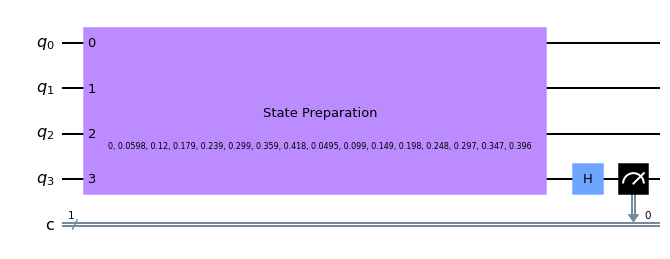

In [6]:
### Cost function
#   params - [a,b] compatible with scipy "minimize" optimiser
#   x and y - training data, need to be omitted for "minimize"
#   Note that x and y do not need to be normalised

# This classical version is for testing only
def costfun_np_inner(params, x, y):

    a, b = params
    
    # Create normalised ansatz
    ansatz = a*x + b
    ansatzNorm = np.linalg.norm(ansatz)
    ansatz = ansatz/ansatzNorm
    
    # Calculate cost with an ansatz
    ynorm = np.linalg.norm(y)
    y = y/ynorm
    y_ansatz = ansatzNorm/ynorm * np.inner(y,ansatz)     

    return (1-y_ansatz)**2

# This quantum version is to be used further
def costfun(params, x, y):

    a, b = params
    
    # Create normalised ansatz
    ansatz = a*x + b
    ansatzNorm = np.linalg.norm(ansatz)
    ansatz = ansatz/ansatzNorm
    
    # Calculate cost with an ansatz
    ynorm = np.linalg.norm(y)
    y = y/ynorm
    y_ansatz = ansatzNorm/ynorm * inner_prod(y,ansatz)     
    y_ansatz = inner_prod(y,ansatz)     

    return (1-y_ansatz)**2

# Testing the cost function
if debug:

    x = np.arange(0,8,1)
    y = x
    print('Data')
    print('x: ', np.round(x, 3))
    print('y: ', np.round(y, 3), '\n')

    ### Test inner product - X and y normalised
    xnorm = np.linalg.norm(x)
    ynorm = np.linalg.norm(y)
    xn = x/xnorm
    yn = y/ynorm

    ### Test cost function
    a = 1.0
    b = 1.0

    print('For y = 1 * x + 1, cost(%2.3f, %2.3f) = %2.4f' % (a, b, costfun([a,b], x, y)))
    display(circ.draw(output='mpl'))  

### Test linear regression

Classical    R2:   0.6829
Classical    MAPE: 0.3618 

COBYLA       R2:   -1.3371
COBYLA       MAPE: 0.939 

Powell       R2:   -4.2765
Powell       MAPE: 0.9997 



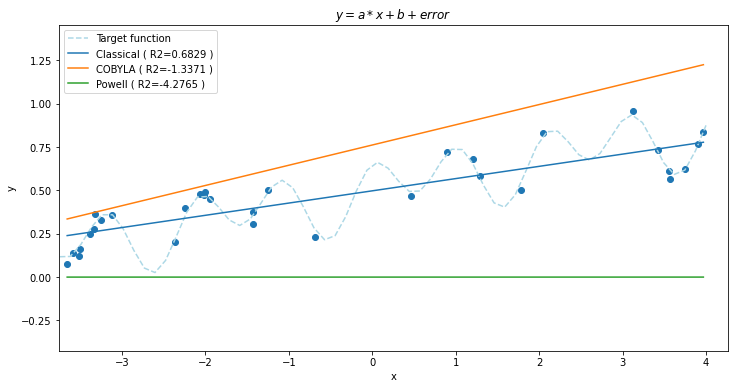

In [7]:
### Test linear regression

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

#  Start random process
np.random.seed(2022)
methods = ['BFGS', 'COBYLA', 'Powell', 'trust-constr'] # 'Nelder-Mead' removed as very slow
methods = ['COBYLA', 'Powell'] # A small subset for the demo
iterations = 200 # 300

# Fetch sample data with noise
x = X_train
y = y_train

# Design X points for ploting (fine grain) and scoring (matching data)
x_plot_fit = np.linspace(min(x), max(x), 100)
x_score_fit = np.linspace(min(x), max(x), len(x))

# Plot the target function
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(X_all, y_all, color='lightblue', linestyle='dashed', label='Target function')
plt.scatter(x,y)

# Plot the classical linear fit
lin_a, lin_b = np.polyfit(x, y, 1)
train_r2 = np.round(r2_score(y, lin_a*x_score_fit+lin_b), 4)
train_mape = np.round(mean_absolute_percentage_error(y, lin_a*x_score_fit+lin_b), 4)
print('Classical'.ljust(12), 'R2:  ', train_r2)
print('Classical'.ljust(12), 'MAPE:', train_mape, '\n')
plt.plot(x_plot_fit, lin_a*x_plot_fit+lin_b, label='Classical ( R2='+str(train_r2)+' )')

# Tute suggests [0.5, 0.5] but it does not work!
x0 = [0.0001,0.0001]

# Generate a, b coefficients for each optimisation method
# and plot its fit
for method in methods:
    out = minimize(lambda params: costfun(params, x, y), x0=x0, 
                method=method, options={'maxiter':iterations}, tol=1e-6)
    out_a = out.x[0]
    out_b = out.x[1]
    train_r2 = np.round(r2_score(y, out_a*x_score_fit+out_b), 4)
    train_mape = np.round(mean_absolute_percentage_error(y, out_a*x_score_fit+out_b), 4)
    print(method.ljust(12), 'R2:  ', train_r2)
    print(method.ljust(12), 'MAPE:', train_mape, '\n')
    plt.plot(x_plot_fit, out_a*x_plot_fit+out_b, label=method+' ( R2='+str(train_r2)+' )')

# Add legend and finalise
plt.legend()
plt.title('$y = a * x + b + error$')
plt.xlim(min(x)-0.1, max(x)+0.3)
plt.ylim(min(y)-0.5, max(y)+0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Extending to Higher Order Fits

We can also extend to fitting to quadratic, cubic, and higher order polynomials. The code remains relatively unchanged, but will update the cost function slightly. We can of course use either the theoretical or practical method for computing the inner products in the following cost function. We are now fitting to an n$^{th}$-order polynomial: $$y = a_0+ a_1 x + a_2 x^2 + \dots + a_n x^n$$

### Cost function for polynomial fits

Data
x:  [0 1 2 3 4 5 6 7]
y:  [7.18000e-01 4.96000e-01 1.22390e+01 4.38770e+01 1.11247e+02 2.23515e+02
 3.92401e+02 6.33118e+02] 

cost([1.2691170332841104; 0.8538691745517175; 0.8694266423840296; 0.19407753499259806]) = 0.6490


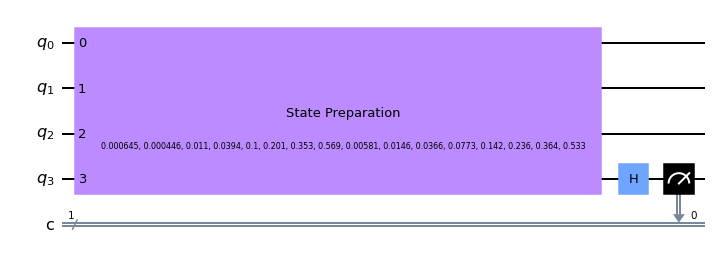

In [8]:
### Cost function
#   params - [a,b] compatible with scipy "minimize" optimiser
#   x and y - training data, need to be omitted for "minimize"
#   Note that x and y do not need to be normalised

# This classical version is for testing only
def polycostfun_np_inner(params, x, y):

    # Create normalised ansatz
    ansatz = params[0]
    for i in range(1,len(params)):
        ansatz += params[i] * x**i
        
    ansatzNorm = np.linalg.norm(ansatz)
    ansatz = ansatz/ansatzNorm
    
    # Calculate cost with an ansatz
    ynorm = np.linalg.norm(y)
    y = y/ynorm
    y_ansatz = ansatzNorm/ynorm * np.inner(y,ansatz)     

    return (1-y_ansatz)**2

# This quantum version is to be used further
def polycostfun(params, x, y):

    # Create normalised ansatz
    ansatz = params[0]
    for i in range(1,len(params)):
        ansatz += params[i] * x**i
        
    ansatzNorm = np.linalg.norm(ansatz)
    ansatz = ansatz/ansatzNorm
    
    # Calculate cost with an ansatz
    ynorm = np.linalg.norm(y)
    y = y/ynorm
    y_ansatz = ansatzNorm/ynorm * inner_prod(y,ansatz)     

    return (1-y_ansatz)**2

# Testing the inner product and cost function
if debug:

    # Prepare test data
    np.random.seed(2022)
    x = np.arange(0,8,1)
    # y = (2*x-1)**3 + [random.uniform(-1,1) for p in range(8)]
    y = 0.3-0.5*x-x**2+2*x**3 + [random.uniform(-1,1) for p in range(8)]

    print('Data')
    print('x: ', np.round(x, 3))
    print('y: ', np.round(y, 3), '\n')

    # Test inner product - X and y normalised
    xnorm = np.linalg.norm(x)
    ynorm = np.linalg.norm(y)
    xn = x/xnorm
    yn = y/ynorm

    # Test cost function
    order = 3
    x0 = [random.uniform(0,2) for p in range(order+1)]
    print(f"cost([{'; '.join(map(str, x0))}]) = %2.4f" % (polycostfun(x0, x, y)))
    display(circ.draw(output='mpl'))

### Test polynomial fit

Classical    R2:   0.6608
Classical    MAPE: 0.3609 

COBYLA       R2:   -4.4386
COBYLA       MAPE: 1.1967 

Powell       R2:   -2.5363
Powell       MAPE: 0.8786 



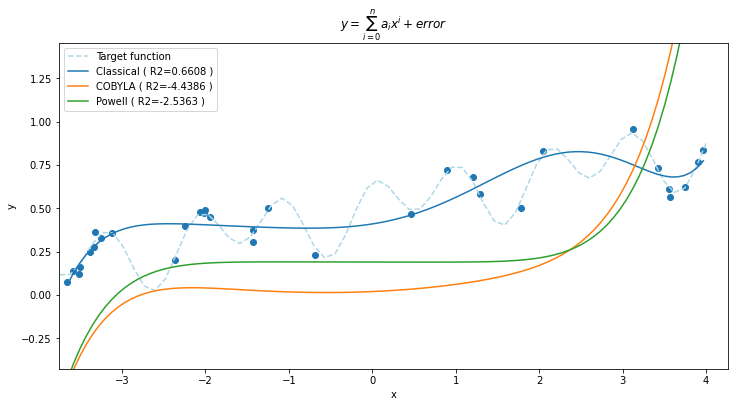

In [9]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error 

# Application of poly coefficients
def q_fit(xfit, coeff, order):
    result = np.zeros(len(xfit))
    for i in range(order+1):
        result += xfit**i*coeff[i]
    return result

# Start random process
np.random.seed(2022)
methods = ['BFGS', 'COBYLA', 'Powell', 'trust-constr'] # 'Nelder-Mead' removed as very slow
methods = ['COBYLA', 'Powell'] # A small subset for the demo
order = 7
iterations = 200 # 300

# Fetch sample data with noise
x = X_train
y = y_train

# Create fits
x_plot_fit = np.linspace(min(x), max(x), 100)
x_score_fit = np.linspace(min(x), max(x), len(x))

# Iteratively plot the chart
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(X_all, y_all, color='lightblue', linestyle='dashed', label='Target function')
plt.scatter(x,y)

# Plot the classical fit
x_class_fit = np.polyfit(x, y, order)
x_class_fit = x_class_fit[::-1]

train_r2 = np.round(r2_score(y, q_fit(x_score_fit, x_class_fit, order)), 4)
train_mape = np.round(mean_absolute_percentage_error(y, q_fit(x_score_fit, x_class_fit, order)), 4)
print('Classical'.ljust(12), 'R2:  ', train_r2)
print('Classical'.ljust(12), 'MAPE:', train_mape, '\n')
plt.plot(x_plot_fit, q_fit(x_plot_fit, x_class_fit, order), label='Classical ( R2='+str(train_r2)+' )')

# Initial guess of all coefficients
# Note that tute suggests them to be random, as follows, but it does not work:
#   x0 = [random.uniform(0,2) for p in range(order+1)]
x0 = [0.0001 for p in range(order+1)]

# Print all other fits
for method in methods:
    out = minimize(lambda params: polycostfun(params, x, y), x0=x0, 
                method=method, options={'maxiter':iterations}, tol=1e-6)
    train_r2 = np.round(r2_score(y, q_fit(x_score_fit, out.x, order)), 4)
    train_mape = np.round(mean_absolute_percentage_error(y, q_fit(x_score_fit, out.x, order)), 4)
    print(method.ljust(12), 'R2:  ', train_r2)
    print(method.ljust(12), 'MAPE:', train_mape, '\n')
    plt.plot(x_plot_fit, q_fit(x_plot_fit, out.x, order), label=method+' ( R2='+str(train_r2)+' )')

# Finalise the plot
plt.legend()
plt.title("$y = \sum_{i=0}^n a_i x^i + error$")
plt.xlim(min(x)-0.1, max(x)+0.3)
plt.ylim(min(y)-0.5, max(y)+0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Versions
- V1 (28/9/2022)
    - V1.6 - Prepared for the TQCEBT workshop as a demo

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table